In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

In [2]:
!pip3 install torch==1.10

    100% |████████████████████████████████| 881.9MB 46kB/s 
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
You are using pip version 19.0.3, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!ls ../input

convnet  intel-image-classification


In [4]:
import torch
from torch import nn
from torchvision import datasets, models, transforms


In [5]:
import torch.utils.data as tdata

In [6]:
data_path_format = '../input/intel-image-classification/seg_{0}/seg_{0}'

In [7]:
np.random.seed(5315)
torch.manual_seed(9784)

In [8]:
# channel_means = (0.4301, 0.4572, 0.4540)
# channel_stds = (0.2698, 0.2680, 0.2983)  # 0.485, 0.456, 0.406
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])
    

In [10]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/intel-image-classification/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/intel-image-classification/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None}


In [11]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [12]:
from sklearn import model_selection

In [13]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [14]:
print(len(val_indices))

1404


In [15]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [16]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/intel-image-classification/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/intel-image-classification/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'train': <torch.utils.data.dataset.Subset object at 0x7f18adfd3780>, 'validation': <torch.uti

In [17]:
from IPython.display import display

In [18]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [19]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [20]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot('111')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

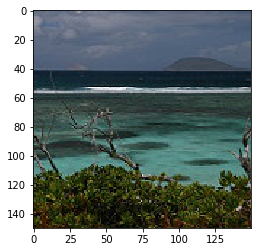

In [21]:
imshow(image_datasets['train'][8555][0]) # 5946

In [22]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cuda_device

In [23]:
cd ../input/convnet

/kaggle/input/convnet


In [24]:
from convnet import IntelNet 
ptr = IntelNet().to(device)

In [25]:
cd ../../working

/kaggle/working


In [26]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [27]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)
                
                
            
        

In [28]:
import time
start = time.time()

In [29]:
optimizer = torch.optim.Adam(ptr.linear.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(20, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.7265960483611384
Epoch 0, iteration 315 training_loss 1.6625336318076411
Epoch 0, iteration 473 training_loss 1.5963967027543466
Epoch 0, iteration 631 training_loss 1.5685151838049103
Epoch 0, iteration 789 training_loss 1.5409545309935944
Epoch 0, val_loss 1.5109246224164963, accuracy = 0.4337606837606838
Epoch 1, iteration 157 training_loss 1.5109282060514522
Epoch 1, iteration 315 training_loss 1.4797145279147956
Epoch 1, iteration 473 training_loss 1.4637323255780377
Epoch 1, iteration 631 training_loss 1.4478336301030992
Epoch 1, iteration 789 training_loss 1.4467104696020294
Epoch 1, val_loss 1.4187885441563346, accuracy = 0.46794871794871795
Epoch 2, iteration 157 training_loss 1.4250780328919617
Epoch 2, iteration 315 training_loss 1.4168512157247037
Epoch 2, iteration 473 training_loss 1.412331959114799
Epoch 2, iteration 631 training_loss 1.3855051918874812
Epoch 2, iteration 789 training_loss 1.3769956925247289
Epoch 2, val_loss 1.3660

In [30]:
end = time.time()
print(end - start)

615.43749833107


In [31]:
from torchvision.utils import make_grid

In [32]:
xx, yy = next(iter(image_dataloaders['validation']))

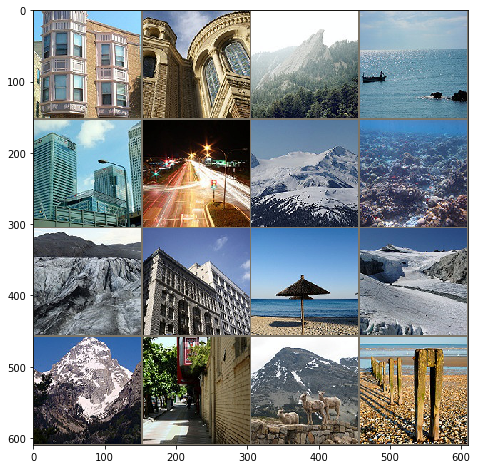

['glacier', 'street', 'mountain', 'glacier', 'glacier', 'street', 'glacier', 'glacier', 'street', 'buildings', 'glacier', 'glacier', 'buildings', 'forest', 'street', 'buildings']
['buildings', 'buildings', 'mountain', 'sea', 'buildings', 'street', 'mountain', 'sea', 'glacier', 'buildings', 'sea', 'glacier', 'glacier', 'street', 'mountain', 'sea']


In [33]:
ptr.eval()
out = ptr(xx.cuda())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [34]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [35]:
from sklearn import metrics

In [36]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [37]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.41      0.32      0.36       437
      forest       0.68      0.81      0.74       474
     glacier       0.52      0.59      0.55       553
    mountain       0.51      0.60      0.55       525
         sea       0.53      0.34      0.41       510
      street       0.52      0.53      0.53       501

   micro avg       0.54      0.54      0.54      3000
   macro avg       0.53      0.53      0.52      3000
weighted avg       0.53      0.54      0.53      3000



In [38]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,141,53,53,44,28,118
forest,9,385,4,11,6,59
glacier,44,10,327,103,53,16
mountain,44,15,82,314,52,18
sea,37,21,140,107,174,31
street,71,81,26,39,17,267
